# Where is the limit?
In this notebook we evaluate the model for classifying images into TC or x-TC. With this we seek to discover which is the boundary between both phenomena according to the model. We hope this can shed some light on the process of discerning between these events, as it is usually a subjective human decision.

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, '../../..')

In our case, we want to ensure we only use resources from GPU 1.

In [2]:
from os import environ
environ["CUDA_VISIBLE_DEVICES"]="1"

## 1. Loading 

Not all sequences serve the purpose of evaluating how good our model is performing. On the one hand we want to avoid using sequences seen while training. On the other hand we should not use any test data as a source of feedback to fine-tune our model. Thus, we will use the **validation set**.

| Training        | Validation      | Test         |
| --------------- |:---------------:| ------------:|
| 197801 - 200610 | 200611 - 201116 | 201117 - end |

Below we use variable `seq_no` to select a sequence.

In [3]:
# Pick sequence
seq_no = 200815
print("Typhoon selected:", seq_no)

Typhoon selected: 200815


### 1.1 Load sequence
Once the sequence has been chosen, we use `PDManager` to load the data dataset and `DataExtractor` to load the corresponding sequence. First, we define the relevant paths for the database to work (note: you should change this based on your system files).

In [4]:
from os.path import join

# Paths to source data
orig_images_dir = '/root/fs9/grishin/database/uintimages/original'
besttrack_dir = '/root/fs9/datasets/typhoon/wnp/jma'

# Path where corrected images are to be stored
corrected_dir = '/root/fs9/grishin/database/uintimages/corrected'

# Path to new database files
db_dir = '/root/fs9/grishin/database'
# Pickle files (used to store dataframes)
images_pkl_path = join(db_dir, 'images.pkl')
corrected_pkl_path = join(db_dir, 'corrected.pkl')
besttrack_pkl_path = join(db_dir, 'besttrack.pkl')
missing_pkl_path = join(db_dir, 'missing.pkl')

Next, we load a sequence using an instance of `DataExtactor`. 

In [5]:
from pyphoon.db.pd_manager import PDManager
from pyphoon.db.data_extractor import DataExtractor

# Create pd_man
man = PDManager()
man.load_original_images(images_pkl_path)
man.load_besttrack(besttrack_pkl_path)
man.load_corrected_images(corrected_pkl_path)

# Define data extractor
de = DataExtractor(original_images_dir=orig_images_dir, corrected_images_dir=corrected_dir, pd_manager=man)

# Load sequence
sequence, sequence_ids, features = de.read_seq(seq_no, ['class'])

### 1.2 Load model
We will use a model previously generated for this task. In particular it has been generated using the architecture presented in the notebook [Final_Model](Final_Model.ipynb). Model and default preprocessor can be found in module `pyphoon.models.tcxtc`.

In [6]:
from pyphoon.models.tcxtc import tcxtcNet, tcxtcPreprocessor
model = tcxtcNet('../weights.hdf5')

Using TensorFlow backend.
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


### 1.3 Pre-process sequence

Next, we first modify the labels such that they convey 'TC' (0) or 'xTC' (1) information.

In [7]:
# Convert labels to TC (0) or xTC (1)
Y = features['class']
Y = [0 if label != 6 else 1 for label in Y]

Next, we use a `MeanImagePreprocessor` to have the sequence in a suitable format for our model.

In [8]:
from pyphoon.models.tcxtc import tcxtcPreprocessor
import numpy as np

# Define preprocessor
preprocessor = tcxtcPreprocessor(resize_factor=(256,256))
# Preprocess sequence
X = np.array([preprocessor.apply(x) for x in sequence])

In [9]:
# Number Typhoon class distribution
print("Number of samples:")
print(" * TC:", sum([1 for label in Y if label == 0]))
print(" * x-TC:", sum([1 for label in Y if label == 1]))

Number of samples:
 * TC: 168
 * x-TC: 97


## 2. Performance

Let us now see how good the model performs on the loaded sequence. We check this by obtaining precision and recall for each category.

In [10]:
from sklearn.metrics import classification_report

# Get complete report
y_pred = model.predict_classes(X)
print(classification_report(Y, y_pred))

             precision    recall  f1-score   support

          0       0.77      0.84      0.81       168
          1       0.67      0.58      0.62        97

avg / total       0.74      0.74      0.74       265



### 2.1 Visualise sequence

Time to see how good we performed on a frame basis. To this end, we will illustrate an animation of the typhoon sequence along with a comparison between the network output and the ground truth class.

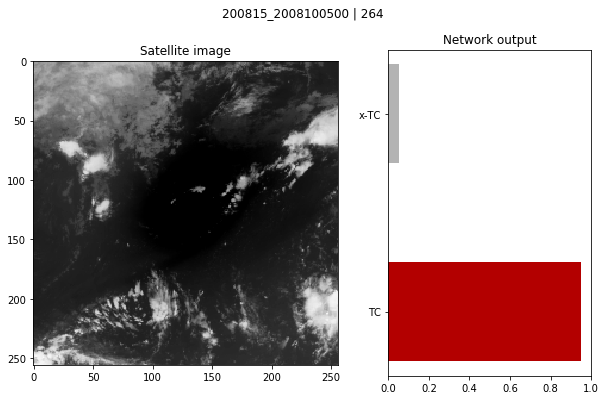

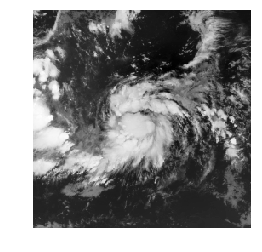

In [12]:
from pyphoon.visualise import DisplayPredictedLabeledSequenceTCxTC
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 6))

p_pred = model.predict(X)[:,0]

animation = DisplayPredictedLabeledSequenceTCxTC(
    images=X[:,:,:,0],
    images_ids=sequence_ids,
    predictions=p_pred, 
    ground_truth=Y,
    fig=fig,
    interval=100
).run_html()

In [13]:
from IPython.display import HTML

HTML(animation)

Let us now show the same information presented above using a static plot. That is, network output vs ground truth values depending on the typhoon sequence frame index.

Text(0.5,0,'Sequence Sample index')

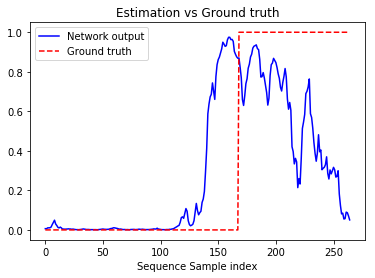

In [14]:
plt.plot(p_pred, 'b', label="Network output")
plt.plot(Y, 'r--', label="Ground truth")
plt.legend()
plt.title("Estimation vs Ground truth")
plt.xlabel('Sequence Sample index')